# A Practical Introduction to Causal Inference and Estimation Theory Through Code

**Author:** François Grolleau
 
**Affiliation:** Stanford Center for Biomedical Informatics Research, Stanford University

**Date:** January 15, 2025

--- 

This tutorial provides an introduction to causal inference and relevant estimation theory using a practical, code-focused approach, complemented by figures and tables. We will explain key concepts using a well-known example from medical research and show how to calculate the *Average Treatment Effect* using various estimators.

## Learning Goals

* Grasp the causal inference framework for determining the average treatment effect.
* Comprehend the concept of a statistical estimand.
* Learn to design and interpret Monte Carlo simulations to evaluate different estimators.

## Prerequisites

* Basic understanding of probability theory (high school or undergraduate level suffices).
* Basic knowledge of supervised learning for classification (e.g., using `sklearn` or `glmnet`).
* Familiarity with scientific programming in `Python` or `R`.
* The standard Anaconda distribution of Python should contain all libraries used in this notebook.

## Table of Contents
- [What is causal inference?](#what-is-causal-inference)
- [Understanding the *Average Treatment Effect* (ATE)](#understanding-the-average-treatment-effect-ate)
- [Formalism](#formalism)
  - [1. Potential Outcomes](#1-potential-outcomes)
  - [2. Our statistical target, or estimand](#2-our-statistical-target-or-estimand)
  - [3. Causal Identifiability Assumptions](#3-causal-identifiability-assumptions)
  - [4. Using the Causal Assumptions to Rearrange the Statistical Target and Eliminate the Potential Outcomes](#4-using-the-causal-assumptions-to-rearrange-the-statistical-target-and-eliminate-the-potential-outcomes)
- [Generate Synthetic Data via Monte Carlo Simulations](#generate-synthetic-data-via-monte-carlo-simulations)
- [Implement the ATE estimators](#implement-the-ate-estimators)
  - [1. G-computation Estimator](#1-g-computation-estimator)
  - [2. IPW and normalized IPW Estimators](#2-ipw-and-normalized-ipw-estimators)
  - [3. AIPW Estimator](#3-aipw-estimator)
  - [4. Combining everything into a single function to compute all the estimators mentioned above](#4-combining-everything-into-a-single-function-to-compute-all-the-estimators-mentioned-above)
- [Compute All Four Estimators on Multiple Equal-Sized Datasets Sampled from the Same Superpopulation](#compute-all-four-estimators-on-multiple-equal-sized-datasets-sampled-from-the-same-superpopulation)
  - [1. Define a Simulation class and test it](#1-define-a-simulation-class-and-test-it)
  - [2. Run 999 Simulations for 5 Different Sample Sizes Increasing Logarithmically from n=500 to n=10,000](#2-run-999-simulations-for-5-different-sample-sizes-increasing-logarithmically-from-n500-to-n10000)
- [Interpret the simulation results](#interpret-the-simulation-results)
  - [1. Retrieve the Results from a Monte Carlo Simulation Comparing the Performance of Various Estimators](#1-retrieve-the-results-from-a-monte-carlo-simulation-comparing-the-performance-of-various-estimators)
  - [2. Visualize the Simulation Results Using Violin Plots for Broader Understanding](#2-visualize-the-simulation-results-using-violin-plots-for-broader-understanding)
  - [3. Describe How Estimator Variances Shrink as Sample Size Increases](#3-describe-how-estimator-variances-shrink-as-sample-size-increases)
- [Conclusion](#conclusion)
- [Further reading](#further-reading)

In this tutorial, we will utilize the following tools and libraries:

In [2]:
import numpy as np                               # Numerical operations
import pandas as pd                              # Data manipulation and analysis
import matplotlib.pyplot as plt                  # Data visualization
from scipy.stats import norm                     # Normal distribution
from scipy.special import expit                  # Sigmoid function (logistic function)
from sklearn.neural_network import MLPClassifier # Multi-layer perceptron for classification (any non-parametric model could be used)
from sklearn.base import clone                   # Cloning Scikit-Learn models
from joblib import Parallel, delayed             # Parallel processing
from pandas import json_normalize                # Flattening nested JSON objects
import seaborn as sns                            # Statistical data visualization
import time                                      # Time tracking
import datetime                                  # Date and time manipulation

The code below is used to suppress sklearn warnings when running jobs in parallel ([issue here](https://stackoverflow.com/a/55595680)). You can safely ignore it without affecting your understanding of the tutorial.

In [3]:
import sys
import warnings
import os

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

In [4]:
# Check if running on Google Colab as default Colab does not support parallel processing
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

print("Running on Colab:", IN_COLAB)

Running on Colab: False


## What is causal inference?

The starting point of the theory of causal inference is the recognition that statistical associations between variables in observational data are not necessarily causal. The goal of causal inference is to establish a conceptual framework to describe *causal* relationships from observed data. In other words, the theory aims to eliminate confounding bias in order to accurately describe the effect of interventions—or actions—on future outcomes.

## Understanding the *Average Treament Effect* (ATE)

* Imagine that in a population of patients, only one characteristic (let's call it X) is relevant to their prognosis and response to a binary treatment. Using this simple, idealized example, we will be able to grasp all the key concepts, making it straightforward to build upon and tackle more complex scenarios later.
* Suppose we know the probability of each patient dying at 30 days based on this characteristic: *(i)* if they do not receive the treatment (T=0), and *(ii)* if they do receive the treatment (T=1).

In [5]:
# Function to simulate the probability of death at 30 days under no treatment
def prob_death_under_no_ttt(X): return expit(np.sin(X))

# Function to simulate the probability of death at 30 days under treatment
def prob_death_under_ttt(X): return expit(0.5*np.sin(X)-.1)

Let's illustrate this concept with a plot.

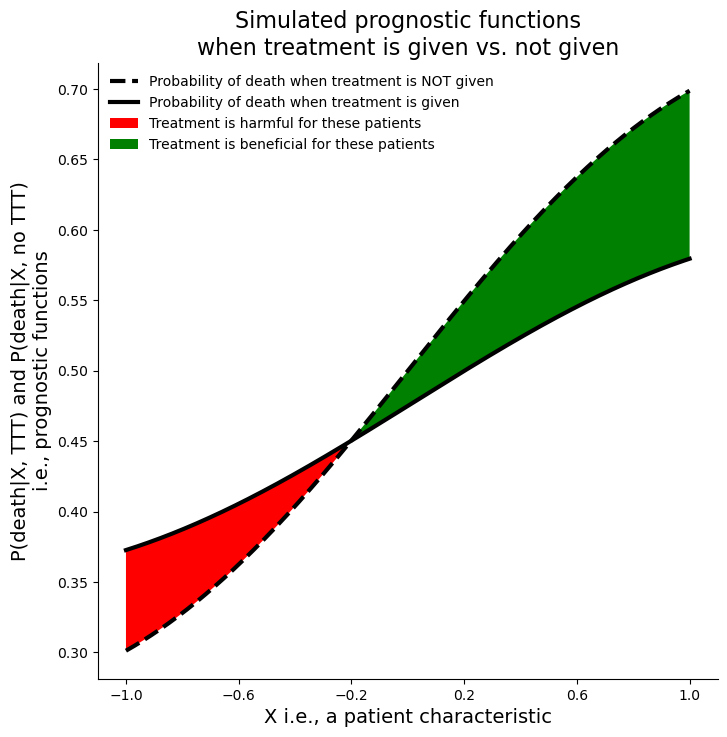

In [6]:
def plot_prob_death(prec=1000):
    x = np.linspace(-1, 1, prec)
    y0 = prob_death_under_no_ttt(x)
    y1 = prob_death_under_ttt(x)
    plt.figure(figsize=(8, 8)) 
    plt.plot(x, y0, color='black', linewidth=3, linestyle='--', label='Probability of death when treatment is NOT given')
    plt.plot(x, y1, color='black', linewidth=3, label='Probability of death when treatment is given')
    plt.fill_between(x, y0, y1, where=(y1 >= y0), facecolor='red', alpha=1, interpolate=True, label='Treatment is harmful for these patients') 
    plt.fill_between(x, y0, y1, where=(y0 > y1), facecolor='green', alpha=1, interpolate=True, label='Treatment is beneficial for these patients') 
    plt.xlabel('X i.e., a patient characteristic', fontsize=14)
    plt.ylabel('P(death|X, TTT) and P(death|X, no TTT)\ni.e., prognostic functions', fontsize=14)
    plt.title('Simulated prognostic functions\nwhen treatment is given vs. not given', fontsize=16)
    plt.legend(frameon=False)
    plt.xticks(np.arange(-1, 1.1, 0.4))
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    
plot_prob_death()

Now, let's examine the benefit of treating each individual patient with characteristic $X = x$.

In [7]:
def plot_individualized_ttt_effects(prec=100000):
    x = np.linspace(-1, 1, prec)
    y = prob_death_under_ttt(x) - prob_death_under_no_ttt(x)
    true_ate = np.mean(y)
    plt.figure(figsize=(7, 7)) 
    plt.axhline(0, color='black', linewidth=1, linestyle='--', label='Line of no treatment effect')
    plt.plot(x[y>=0], y[y>=0], color='red', linewidth=5, label='Treatment is harmful for these patients') 
    plt.plot(x[y<0], y[y<0], color='green', linewidth=5, label='Treatment is beneficial for these patients')
    plt.axhline(true_ate, color='black', linewidth=5, label=f'ATE, assuming a uniform distribution of X ({true_ate*100:.2f}%)')
    plt.xlabel('X i.e., a patient characteristic', fontsize=14)
    plt.ylabel('P(death|X, TTT) - P(death|X, no TTT)\ni.e., conditional treatment effect', fontsize=14)
    plt.title('Simulated conditional treatment effects', fontsize=16)
    plt.legend(frameon=False)
    plt.xticks(np.arange(-1, 1.1, 0.4))
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    return true_ate

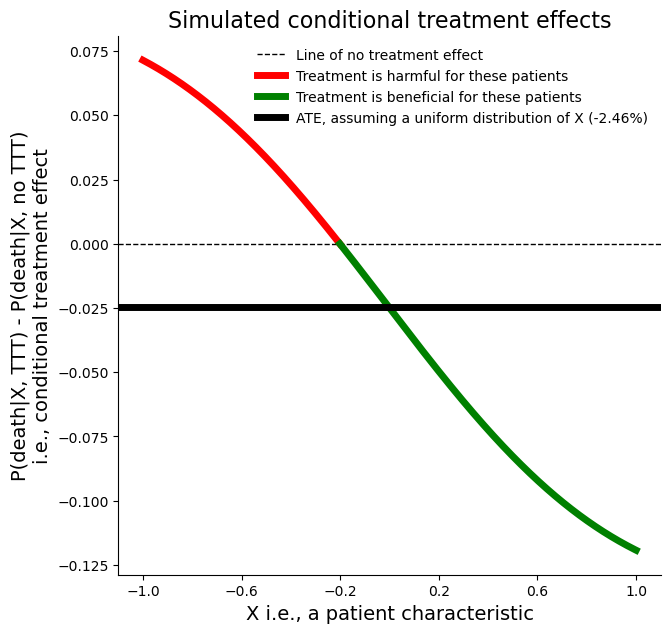

In [8]:
true_ate = plot_individualized_ttt_effects();

By assuming that all patient characteristics $X = x$ are equally likely within the population, the benefit of treating everyone versus treating no one is represented by the solid horizontal line. This is known as the *Average Treatment Effect* (ATE).

## Formalism

### 1. Potential Outcomes
In causal inference, we assume that each patient exists in two copies: i) one in which the patient receives the treatment, and ii) one in which they do not receive the treatment.
We only get to see the outcome for the scenario that corresponds to the treatment the patient actually received in the real world. However, the outcome for the alternate scenario—the one we can't see—also exists. This unobserved outcome is called a latent variable, or in this context, a potential outcome.

The data are independently and identically distributed (i.i.d.) from some distribution $P$:
$$ (X,T,Y, \textcolor{red}{Y^{t=0}, Y^{t=1}}) \overset{\text{iid}}{\sim} P$$
where only $(X,T,Y)$ are observed, and $\textcolor{red}{Y^{t=0}, Y^{t=1}}$ are latent variables known as the potential outcomes.

### 2. Our statistical target, or estimand

The Average Treatment Effect (ATE) is our statistical target, or estimand. It represents the population-level effect of treatment $T=1$ on the outcome $Y$ in a hypothetical infinite randomized trial where the treatment is compared to the control $T=0$. It is formally defined as: $$\Delta \stackrel{\text{def}}{=}E_P[Y^{t=1}-Y^{t=0}].$$

### 3. Causal Identifiability Assumptions
* **Consistency Assumption (aka Stable Unit Treatment Value Assumption)**: A treatment option is consistent regardless of how it is administered; that is, there are no 'versions' of a treatment option. It is usually stated as: $$Y=TY^{t=1}+(1-T)Y^{t=0}.$$
* **Ignorability Assumption (aka No Unmeasured Confounding Assumption)**: All variables that causally affect both the treatment $T$ and the occurrence of the outcome $Y$ are measured. This assumption is denoted as $$\{Y^{t=0}, Y^{t=1}\} \perp T|X.$$
* **Overlap Assumption (aka Positivity Assumption)**: For all realistic levels of $X$, individuals could receive either of the two treatment options with a non-zero probability. This assumption is written as follows. There exists a constant $\eta$ such that:
$$\forall x \in \mathcal{X}, \quad 0 < \eta <  E_P[T|X=x] < 1 - \eta < 1.$$

### 4. Using the Causal Assumptions to Rearrange the Statistical Target and Eliminate the Potential Outcomes
Using the assumptions above, it can be shown that:
$$
\begin{align*}
\Delta &\stackrel{\text{def}}{=}E_P[Y^{t=1}-Y^{t=0}] \\
       &= E_P\Big[E_P(Y|T=1,X)-E_P(Y|T=0,X)\Big] \\
       &= E_P\Big[\frac{TY}{E_P[T|X]}-\frac{(1-T)Y}{1-E_P[T|X]}\Big] \\
       &= E_P\Big[E_P(Y|T=1,X)-E_P(Y|T=0,X) + \frac{(2T-1)\{Y-E_P(Y|T,X)\}}{TE_P[T|X]+(1-T)\{1-E_P[T|X]\}}\Big].
\end{align*}
$$

<details>
    <summary>See G-computation (second equality) proof</summary>

\begin{align*}
\Delta &\stackrel{\text{def}}{=}E_P[Y^{t=1}-Y^{t=0}] \\
       &=E_P\Big[E_P(Y^{t=1}|X)-E_P(Y^{t=0}|X)\Big] \tag*{(Tower rule + linearity of expectations)}\\
       &=E_P\Big[E_P(Y^{t=1}|X,T=1)-E_P(Y^{t=0}|X,T=0)\Big] \tag*{(Ignorability Assumption)}\\
       &=E_P\Big[E_P(Y|X,T=1)-E_P(Y|X,T=0)\Big] \tag*{(Consistency Assumption)}\\
\end{align*}

</details>

<details>
    <summary>See IPW (third equality) proof</summary>

\begin{align*}
\Delta &\stackrel{\text{def}}{=}E_P[Y^{t=1}-Y^{t=0}] \\
       &=E_P\Big[E_P(Y^{t=1}|X)-E_P(Y^{t=0}|X)\Big] \tag*{(Tower rule + linearity of expectations)}\\
       &=E_P\Big[\frac{E_P(T|X)E_P(Y^{t=1}|X)}{E_P(T|X)}-\frac{E_P(1-T|X)E_P(Y^{t=0}|X)}{E_P(1-T|X)}\Big] \\
       &=E_P\Big[\frac{E_P(TY^{t=1}|X)}{E_P(T|X)}-\frac{E_P[(1-T)Y^{t=0}|X]}{E_P(1-T|X)}\Big] \tag*{(Ignorability Assumption)}\\
       &=E_P\Big[E_P\big[\frac{TY^{t=1}}{E_P(T|X)}|X\big]-E_P\big[\frac{(1-T)Y^{t=0}}{E_P(1-T|X)}|X\big]\Big] \tag*{(``Taking out what is known" rule)}\\
       &=E_P\Big[\frac{TY^{t=1}}{E_P(T|X)}-\frac{(1-T)Y^{t=0}}{E_P(1-T|X)}\Big] \\
       &=E_P\Big[\frac{TY}{E_P(T|X)}-\frac{(1-T)Y}{E_P(1-T|X)}\Big] \tag*{(Consistency Assumption)}
\end{align*}

</details>

<details>
    <summary>See AIPW (fourth equality) proof</summary>

Note that,
\begin{align*}
&E_P\Big[\frac{(2T-1)\{Y-E_P(Y|T,X)\}}{TE_P[T|X]+(1-T)\{1-E_P[T|X]\}}\Big]\\
=&E_P\Big[\frac{(2T-1)\{Y-E_P(Y|T,X)\}}{TE_P[T|X]+(1-T)\{1-E_P[T|X]\}}|X,T\Big]\\
=&\frac{2T-1}{TE_P[T|X]+(1-T)\{1-E_P[T|X]\}}E_P\Big[Y-E_P(Y|T,X)|X,T\Big] \tag*{(``Taking out what is known" rule)}\\
=&\frac{2T-1}{TE_P[T|X]+(1-T)\{1-E_P[T|X]\}}\Big[E_P(Y|X,T)-E_P(Y|T,X)\Big] = 0.
\end{align*}
Thus,
\begin{align*}
\Delta &\stackrel{\text{def}}{=}E_P[Y^{t=1}-Y^{t=0}] \\
       &= E_P\Big[E_P(Y|T=1,X)-E_P(Y|T=0,X)\Big] \tag*{(G-computation proof)}\\
       &= E_P\Big[E_P(Y|T=1,X)-E_P(Y|T=0,X)\Big] + E_P\Big[\frac{(2T-1)\{Y-E_P(Y|T,X)\}}{TE_P[T|X]+(1-T)\{1-E_P[T|X]\}}\Big]\\
       &= E_P\Big[E_P(Y|T=1,X)-E_P(Y|T=0,X) + \frac{(2T-1)\{Y-E_P(Y|T,X)\}}{TE_P[T|X]+(1-T)\{1-E_P[T|X]\}}\Big].
\end{align*}


</details>

This suggests three estimators for $\Delta$ named G-computation, Inverse Probability Weighting, and Augmented Inverse Probability Weighting, respectively:
$$
\begin{align*}
\hat{\Delta}_G &= n^{-1} \sum_{i=1}^n \hat{q}(1,X_i)-\hat{q}(0,X_i), \\
\hat{\Delta}_{IPW} &= n^{-1} \sum_{i=1}^n \frac{T_iY_i}{\hat{e}(X_i)}-\frac{(1-T_i)Y_i}{1-\hat{e}(X_i)}, \\
\hat{\Delta}_{AIPW} &= \sum_{i=1}^n \hat{q}(1,X_i)-\hat{q}(0,X_i) + \frac{(2T_i-1)\{Y_i-\hat{q}(T_i,X_i)\}}{T_i\hat{e}(X_i) +(1-T_i)\{1-\hat{e}(X_i)\}}.
\end{align*}
$$
where:
* $\hat{q}(T,X)$ is an estimator for the prognostic function $E_P(Y|T,X),$ and
* $\hat{e}(X)$ is an estimator for the propensity score function $E_P(T|X)$.

Furthermore, authors have suggested a normalized version of the IPW estimator, which should have better theoretical properties (specifically, a smaller asymptotic variance, as we will see later):
$$
\begin{align*}
\hat{\Delta}_{nIPW} &= \sum_{i=1}^n \frac{\frac{T_iY_i}{\hat{e}(X_i)}}{\sum_{i=1}^n\frac{T_i}{\hat{e}(X_i)}}-\frac{\frac{(1-T_i)Y_i}{1-\hat{e}(X_i)}}{\sum_{i=1}^n\frac{1-T_i}{1-\hat{e}(X_i)}}.
\end{align*}
$$
Our goal in the next section is to *implement* these formulas to see how these estimators perform in practice, but first, let's generate some data.

## Generate Synthetic Data via Monte Carlo Simulations
Consistent with the framework introduced earlier, we will generate data as follows:
$$
\begin{align*}
&X \sim \text{Uniform}[-1,1] \\
&T|X \sim \text{Bernoulli}\{e(X)\} \\
&Y^{t=0}|X \sim \text{Bernoulli} \{ q(0,X) \} \\
&Y^{t=1}|X \sim \text{Bernoulli} \{ q(1,X) \} \\
&Y=TY^{t=1}+(1-T)Y^{t=0} \\
\end{align*}
$$
where:
$$
\begin{align*}
&e(X) = \cos(X),\\
&q(0,X) = \, \text{expit}\{\sin(X)\}, \, \text{and} \\
&q(1,X) = \, \text{expit}\{\sin(0.5X-0.1)\}.
\end{align*}
$$
Let's see how we can implement this in code below.

In [9]:
def generate_data(n_samples):
    # sample X from a uniform distribution
    X = np.random.uniform(-1,1, n_samples)

    # sample from a bernoulli distribution
    T = np.random.binomial(1, np.cos(X), n_samples)
    Y_t0 = np.random.binomial(1, prob_death_under_no_ttt(X), n_samples)
    Y_t1 = np.random.binomial(1, prob_death_under_ttt(X), n_samples)

    # apply the consistency assumption
    Y = T * Y_t1 + (1-T) * Y_t0
    
    return pd.DataFrame({'X': X, 'T': T, 'Y': Y, 'Y_t0': Y_t0, 'Y_t1': Y_t1})
    

Let's test this data-generating function by creating a superpopulation of 10,000 individuals and checking the first few rows.

In [10]:
# test the function
super_population = generate_data(10000)

# print the first few rows of the dataframe in big font size for better readability
styled_df = super_population.head().style.set_table_styles(
    [{'selector': 'thead th', 'props': [('font-size', '26px')]},
     {'selector': 'tbody td', 'props': [('font-size', '24px')]}]
).set_properties(**{'text-align': 'center'})

# Display the styled DataFrame
display(styled_df)

,X,T,Y,Y_t0,Y_t1
0,0.614456,1,1,0,1
1,0.341690,1,1,1,1
2,-0.065985,1,0,0,0
3,0.573614,1,1,1,1
4,-0.326704,1,0,1,0


## Implement the ATE estimators
### 1. G-computation Estimator

In [11]:
def g_comp_ate_estimator(data, sk_model):
    """
    Input:
    - data: a pandas DataFrame with columns 'X', 'T', and 'Y'
    - sk_model: a Scikit-Learn model that can predict probabilities of Y given X
    Output:
    - gcomp_ate_estimate (float): the g-computation estimate of the ATE
    - pr_model_t1: the fitted model for predicting Y given X for T == 1
    - pr_model_t0: the fitted model for predicting Y given X for T == 0
    """
    # Prepare prognostic models for T == 1 and T == 0
    pr_model_t1 = clone(sk_model)
    pr_model_t0 = clone(sk_model)
    
    # Get inputs and targets for T == 1 (i.e., subgroup where treatment is given)
    inputs_t1 = data["X"][data["T"]==1].values.reshape(-1, 1)
    targets_t1 = data["Y"][data["T"]==1]
    
    # Fit the model for the subgroup where treatment is given
    pr_model_t1.fit(inputs_t1, targets_t1)

    # For all patients, predict probabilities of death if the treatment were given
    predicted_proba_t1 = pr_model_t1.predict_proba(data["X"].values.reshape(-1, 1))[:,1]
    
    # Get inputs and targets for T == 0 (i.e., subgroup where treatment is not given)
    inputs_t0 = data["X"][data["T"]==0].values.reshape(-1, 1)
    targets_t0 = data["Y"][data["T"]==0].values
    
    # Fit the model for the subgroup where treatment is NOT given
    pr_model_t0.fit(inputs_t0, targets_t0)
    
    # For all patients, predict probabilities of death if the treatment were NOT given
    predicted_proba_t0 = pr_model_t0.predict_proba(data["X"].values.reshape(-1, 1))[:,1]
    
    # Compute the individual contributions to the g-computation estimate of the ATE
    i_gcomp_ate_estimate = predicted_proba_t1 - predicted_proba_t0
    
    # Compute the g-computation estimate of the ATE
    gcomp_ate_estimate = np.mean(i_gcomp_ate_estimate)
    return gcomp_ate_estimate, i_gcomp_ate_estimate, pr_model_t1, pr_model_t0

Let's test the G-Computation estimator function on a sample of 1,000 individuals from the superpopulation.

In [12]:
# take a sample of size 10000 from the super_population
data = super_population.iloc[:1000, :3]

# Instantiate a nonparametric classifier (multi-layer perceptron with 4 hidden units here but could be any other model)
mlp_model = MLPClassifier(hidden_layer_sizes=(4), activation="logistic", solver="lbfgs", max_iter=5000, random_state=42)

# test the estimator function
g_comp_ate_estimator(data, mlp_model)

(np.float64(0.07631969416511822),
 array([-1.77710131e-01,  4.94904579e-01,  4.67854230e-01, -1.86509435e-01,
         7.20949004e-02, -1.97069633e-01,  6.67459373e-02,  4.85702608e-01,
        -1.52217240e-01,  4.79689051e-01,  4.80743513e-01,  5.02821901e-01,
        -1.97094122e-01,  5.43471469e-02, -1.35526570e-01,  4.85600379e-01,
         1.19829335e-02, -1.67782725e-01,  4.55988445e-02, -1.05178880e-01,
         1.74612660e-02,  4.89966170e-01,  4.91686224e-01, -2.07166626e-01,
         4.52230435e-01,  3.36756924e-02, -4.75868795e-01, -1.44994377e-01,
         4.52327139e-01,  4.75241166e-01, -2.05053299e-01, -1.78368646e-01,
         4.50839768e-01,  4.65264277e-01,  4.90841153e-01,  2.47639417e-02,
        -1.00237537e-01, -1.03290180e-01, -1.19718202e-01, -1.20044237e-01,
         3.10358823e-02, -3.98064189e-03,  4.65087731e-01, -1.34564897e-01,
        -4.64859313e-01,  4.94709942e-01, -1.41873980e-01, -1.90544941e-01,
         4.98975404e-01,  1.02583235e-02,  4.98197362e

### 2. IPW and normalized IPW Estimators

In [13]:
def ipw_ate_estimator(data, sk_model):
    """
    Input:
    - data: a pandas DataFrame with columns 'X', 'T', and 'Y'
    - sk_model: a Scikit-Learn model that can predict probabilities of T given X
    Output:
    - ipw_ate_estimate (float): the IPW estimate of the ATE
    - ipw_ate_estimate_normalized (float): the IPW estimate of the ATE using normalized weights
    - ps_model: the fitted model for predicting T given X
    """
    # Prepare the propensity score model P(T=1|X)
    ps_model = clone(sk_model)
    
    # Get inputs and targets for the propensity score model
    inputs = data["X"].values.reshape(-1, 1)
    targets = data["T"]
    
    # Fit the propensity score model P(T=1|X)
    ps_model.fit(inputs, targets)

    # For all patients, predict probabilities of receiving treatment
    predicted_proba = ps_model.predict_proba(data["X"].values.reshape(-1, 1))[:,1]
    
    # Calculate the weights of the treated as the inverse probabilty of being treated
    w_t1 = data["T"] / predicted_proba
    
    # Calculate the weights of the untreated as the inverse probabilty of being NOT being treated 
    w_t0 = (1 - data["T"]) / (1 - predicted_proba)
    
    # Compute the IPW estimate of the ATE
    ipw_ate_estimate = np.mean((w_t1 - w_t0) * data["Y"])
    
    # Normalize the weights
    w_t1_normalized = w_t1 / np.sum(w_t1)
    w_t0_normalized = w_t0 / np.sum(w_t0)
    
    # Compute the IPW estimate of the ATE using normalized weights
    ipw_ate_estimate_normalized = np.sum((w_t1_normalized - w_t0_normalized) * data["Y"])
    
    return ipw_ate_estimate, ipw_ate_estimate_normalized, ps_model

Let's test the IPW/normalized IPW estimator function on a sample of 1,000 individuals from the superpopulation.

In [14]:
#test the estimator function
ipw_ate_estimator(data, mlp_model)

(np.float64(0.07232470526790441),
 np.float64(0.027716780095206412),
 MLPClassifier(activation='logistic', hidden_layer_sizes=4, max_iter=5000,
               random_state=42, solver='lbfgs'))

### 3. AIPW Estimator

In [15]:
def aipw_ate_estimator(data, i_gcomp_ate_estimate, pr_model_t1, pr_model_t0, ps_model):
    """
    Input:
    - data: a pandas DataFrame with columns 'X', 'T', and 'Y'
    - i_gcomp_ate_estimate: individual contributions to the g-computation estimate of the ATE
    - pr_model_t1: the fitted model for predicting Y given X for T == 1
    - pr_model_t0: the fitted model for predicting Y given X for T == 0
    - ps_model: the fitted model for predicting T given X
    Output:
    - aipw_ate_estimate (float): the AIPW estimate of the ATE
    - var_aipw_ate_estimate (float): the variance of the AIPW estimator
    """
    top_left = 2 * data["T"] - 1
    pr_model_preds = data["T"] * pr_model_t1.predict_proba(data["X"].values.reshape(-1, 1))[:,1] + (1 - data["T"]) * pr_model_t0.predict_proba(data["X"].values.reshape(-1, 1))[:,1]
    top_right = data["Y"] - pr_model_preds
    denominator = data["T"] * ps_model.predict_proba(data["X"].values.reshape(-1, 1))[:,1] + (1 - data["T"]) * (1 - ps_model.predict_proba(data["X"].values.reshape(-1, 1))[:,1])
    correction_term = top_left * top_right / denominator
    
    # Compute the individual contributions to the AIPW estimate of the ATE
    i_apiw_ate_estimate = i_gcomp_ate_estimate + correction_term
    
    # Compute the AIPW estimate of the ATE
    aipw_ate_estimate = np.mean(i_apiw_ate_estimate)
    
    # Compute the variance of the AIPW estimator
    var_aipw_ate_estimate = np.sum((i_apiw_ate_estimate - aipw_ate_estimate)**2)/(len(data)-1)/len(data)
    
    return aipw_ate_estimate, var_aipw_ate_estimate

### 4. Combining everything into a single function to compute all the estimators mentioned above

In [16]:
def apply_estimators(data, sk_model):
    """
    Input:
    - data: a pandas dataframe containing the data with columns X, T, and Y
    - sk_model: an instance of a scikit-learn classifier
    Output:
    - gcomp_ate_estimate: the g-computation estimate of the ATE
    - ipw_ate_estimate: the IPW estimate of the ATE
    - ipw_ate_estimate_normalized: the IPW estimate of the ATE using normalized weights
    - aipw_ate_estimate: the AIPW estimate of the ATE
    - var_aipw_ate_estimate: the variance of the AIPW estimator
    """
    gcomp_ate_estimate, i_gcomp_ate_estimate, pr_model_t1, pr_model_t0 = g_comp_ate_estimator(data, sk_model)
    ipw_ate_estimate, ipw_ate_estimate_normalized, ps_model = ipw_ate_estimator(data, sk_model)
    aipw_ate_estimate, var_aipw_ate_estimate = aipw_ate_estimator(data, i_gcomp_ate_estimate, pr_model_t1, pr_model_t0, ps_model)
    return gcomp_ate_estimate, ipw_ate_estimate, ipw_ate_estimate_normalized, aipw_ate_estimate, var_aipw_ate_estimate

## Compute All Four Estimators on Multiple Equal-Sized Datasets Sampled from the Same Superpopulation
### 1. Define a Simulation class and test it

In [17]:
class Simulation:
    def __init__(self, s_size, n_sim, generate_data, true_ate, sk_model):
        self.s_size = s_size
        self.n_sim = n_sim
        self.generate_data = generate_data
        self.true_ate = true_ate
        self.sk_model = sk_model
    
    def sim_superpop_and_idxs(self):
        # Create a superpopulation that of size s_size*n_sim
        self.superpop = self.generate_data(self.s_size * self.n_sim)[["X", "T", "Y"]]

        # Create a list of lists of indices for the simulations
        self.sim_idx_s = [range(it * self.s_size, it * self.s_size + self.s_size) for it in range(self.n_sim)]
        self.sim_idx_s = list(map(list, self.sim_idx_s))
        # sim_idx_s is of the form [[0, 1,.., s_size-1], [s_size, s_size+1,.., 2*s_size-1], ...]

        # Confirm that the superpopulation is large enough for the simulation size
        assert self.sim_idx_s[-1][-1] < self.superpop.shape[0], "The dataset is too small for the simulation size (sample size * number of simulations)"
        
    def run_one_simulation(self, sim_idx):
        # Prepare the data for the simulation iteration
        data = self.superpop.iloc[sim_idx]
        gcomp, ipw, ipw_normalized, aipw, var_aipw = apply_estimators(data, self.sk_model)
        
        # Save the results by appending a new row to the results dataframe
        iteration_result = {"iteration": sim_idx[0]//len(sim_idx),
                            "gcomp": gcomp,
                            "ipw": ipw,
                            "ipw_normalized": ipw_normalized,
                            "aipw": aipw,
                            "var_aipw": var_aipw}
        return iteration_result

    def run_all_simulations(self):
        if IN_COLAB:
            # Run all simulations in parallel
            self.results = Parallel(n_jobs=-1)(delayed(self.run_one_simulation)(sim_idx) for sim_idx in self.sim_idx_s)
        else:
            # Run all simulations sequentially
            self.results = [self.run_one_simulation(sim_idx) for sim_idx in self.sim_idx_s]
            
        # Save the results in a dataframe
        self.results = pd.DataFrame(self.results)
    
    def process_results(self):
        # Calulate bias, variance, MSE and coverage
        estimators = ["gcomp", "ipw", "ipw_normalized", "aipw"]
        mse = (self.results[estimators] - self.true_ate).pow(2).mean(axis=0)
        bias = self.results[estimators].mean(axis=0) - self.true_ate
        variance = self.results[estimators].var(axis=0) # this is normalized by N-1 by default
        self.analyzed_results = {"n_sim": self.n_sim, "s_size": self.s_size, "mse": dict(mse), "bias": dict(bias), "variance": dict(variance)}

    def process_cis(self, alpha=0.05):
        aipw_estimates = np.array(self.results["aipw"])[:, np.newaxis]
        z = norm.ppf(1-alpha/2)
        z_s = np.array([-z, 0, z]).reshape(-1, 3)
        standard_errors = np.sqrt(np.array(self.results["var_aipw"])[:, np.newaxis])        
        ci_s = aipw_estimates + z_s * standard_errors
        self.ci_length = np.mean(ci_s[:, 2] - ci_s[:, 0])
        self.coverage = np.mean((ci_s[:, 0] < true_ate) & (true_ate < ci_s[:, 2]))

* Let's test this class by generating 999 datasets, each with a sample size of 200, and estimating the ATE using the four estimators on the first dataset.

In [18]:
sim_instance = Simulation(s_size=200, n_sim=999, generate_data=generate_data, true_ate=true_ate, sk_model=mlp_model)
sim_instance.sim_superpop_and_idxs()
sim_instance.run_one_simulation(sim_instance.sim_idx_s[0])

{'iteration': 0,
 'gcomp': np.float64(-0.020108960837707714),
 'ipw': np.float64(0.1841545030527239),
 'ipw_normalized': np.float64(0.14598189997471495),
 'aipw': np.float64(0.001955128415529881),
 'var_aipw': np.float64(0.005273817316142664)}

* Now, let's try to estimate the ATE using the four estimators on the second dataset.

In [19]:
sim_instance.run_one_simulation(sim_instance.sim_idx_s[1])

{'iteration': 1,
 'gcomp': np.float64(-0.25935252459166686),
 'ipw': np.float64(0.18177861360828476),
 'ipw_normalized': np.float64(-0.05825456102036926),
 'aipw': np.float64(-0.2567197507903551),
 'var_aipw': np.float64(0.0029055511109596405)}

* Finally, let's estimate the ATE using the four estimators on all 999 datasets.

In [50]:
sim_instance.run_all_simulations()

* Let's check the results of computing all four estimators on our 999 datasets.

In [52]:
sim_instance.results

,iteration,gcomp,ipw,ipw_normalized,aipw,var_aipw
0,0,0.123664,0.169823,0.040517,0.116488,0.002131
1,1,-0.076057,0.191428,0.030105,-0.069265,0.003544
2,2,-0.239402,0.047991,-0.156764,-0.215044,0.004990
3,3,-0.137199,0.104168,-0.010102,-0.107969,0.004968
4,4,0.086774,0.066115,-0.050334,0.001405,0.013669
...,...,...,...,...,...,...
994,994,0.042154,0.137850,-0.105427,0.043968,0.002733
995,995,-0.093069,-0.175583,-0.178239,-0.179266,0.022376
996,996,-0.188381,0.062049,-0.148913,-0.187767,0.002210
997,997,0.036541,0.018321,0.021869,0.025191,0.008010


* Analyze the results in terms of MSE, Bias, and Variance of the estimators (we will delve into this in the result section)

In [54]:
sim_instance.process_results()
sim_instance.analyzed_results

{'n_sim': 999,
 's_size': 200,
 'mse': {'gcomp': 0.026512094476166044,
  'ipw': 0.03220493109282359,
  'ipw_normalized': 0.018210115692953957,
  'aipw': 0.02699611210595354},
 'bias': {'gcomp': -0.003175684284604883,
  'ipw': 0.12213875838752565,
  'ipw_normalized': -0.004662376796948878,
  'aipw': -0.0027891517514247247},
 'variance': {'gcomp': 0.026528564625235534,
  'ipw': 0.017304376490566,
  'ipw_normalized': 0.01820660276314798,
  'aipw': 0.027015375156034707}}

### 2. Run 999 Simulations for 5 Different Sample Sizes Increasing Logarithmically from n=500 to n=10,000

In [56]:
# In this simulation, we will use a MLP model with 5 hidden units as nuisance models
mlp_model = MLPClassifier(hidden_layer_sizes=(5,), max_iter=1000, random_state=42, verbose=False)

In [57]:
# Define the sample sizes for the simulations
s_sizes = np.logspace(np.log10(500.5), np.log10(10000), num=5, dtype=int)
s_sizes

array([  500,  1058,  2237,  4729, 10000])

In [58]:
all_results = []

sim_start_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
print(f"Starting simulation at {sim_start_time}\n")
for s_size in s_sizes:
    start_time = time.time()
    print(f"Running simulations for sample size n={s_size}...\n")
    
    sim = Simulation(s_size=s_size, n_sim=999, generate_data=generate_data, true_ate=true_ate, sk_model=mlp_model)
    sim.sim_superpop_and_idxs()
    sim.run_all_simulations()
    sim.process_results()
    sim.process_cis()
    all_results.append(sim)
    
    end_time = time.time()
    hours, rem = divmod(end_time - start_time, 3600)
    minutes, seconds = divmod(rem, 60)
    
    print(f"... took {int(hours)}h {int(minutes)}m {seconds:.1f}s\n")
        
sim_end_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
print(f"Simulation finished at {sim_end_time}")

Starting simulation at 2025-01-13-18-02-38

Running simulations for sample size n=500...

... took 0h 0m 10.5s

Running simulations for sample size n=1058...

... took 0h 0m 25.2s

Running simulations for sample size n=2237...

... took 0h 0m 48.1s

Running simulations for sample size n=4729...

... took 0h 1m 18.1s

Running simulations for sample size n=10000...

... took 0h 2m 26.2s

Simulation finished at 2025-01-13-18-07-46


## Interpret the simulation results
### 1. Retrieve the Results from a Monte Carlo Simulation Comparing the Performance of Various Estimators

* Get the raw (float64) results

In [61]:
float_res_df = json_normalize([sim.analyzed_results for sim in all_results])
float_res_df.columns = [col.replace('.', '_') for col in float_res_df.columns]
float_res_df

,n_sim,s_size,mse_gcomp,mse_ipw,mse_ipw_normalized,mse_aipw,bias_gcomp,bias_ipw,bias_ipw_normalized,bias_aipw,variance_gcomp,variance_ipw,variance_ipw_normalized,variance_aipw
0,999,500,0.002615,0.011813,0.003517,0.003191,0.014628,0.094944,-0.002036,0.004981,0.002404,0.002802,0.003516,0.003170
1,999,1058,0.001713,0.013229,0.001973,0.001714,0.025328,0.103792,0.000788,0.007404,0.001072,0.002458,0.001975,0.001661
2,999,2237,0.000790,0.011443,0.001225,0.001047,0.013530,0.100943,-0.000537,0.003687,0.000607,0.001254,0.001226,0.001034
3,999,4729,0.000359,0.008046,0.000612,0.000526,0.008963,0.086650,-0.000738,0.001944,0.000279,0.000538,0.000612,0.000523
4,999,10000,0.000179,0.005751,0.000316,0.000280,0.004842,0.073810,-0.001690,-0.000068,0.000156,0.000303,0.000314,0.000280


* Enhance the result table for better readability

In the table above, green cells indicate the best values for MSE (lower values preferred), bias (values close to zero preferred), and variance (lower values preferred) for a given sample size.

In [88]:
# Prepare the table for better visualization
# (this part is a bit convoluted and not particulary insighful)
def highlight_cells(x):
    # Create an empty DataFrame with the same shape as x
    df = pd.DataFrame('', index=x.index, columns=x.columns)
    
    # Apply the mask only to numeric columns
    df.iloc[:, 2:] = 'background-color: gray'
    for col in x.columns:
        if "bias" in col:
            df.loc[:, col] = 'background-color: darkgray'
        for metric in ["mse", "bias", "variance"]:
            if metric in col:
                # gymastic below to remove minus signs as appropriate and compare color the winner estimators in green
                mask = x[col].apply(lambda x: x[1:-1] if x[0] == "-" else x[:-1]) == results_df[[f"{metric}_gcomp", f"{metric}_ipw", f"{metric}_ipw_normalized", f"{metric}_aipw"]].apply(lambda xx: min([x[1:-1] if x[0] == "-" else x[:-1] for x in xx]), axis=1)
                df.loc[mask, col] = 'background-color: green'    
    return df

# Define a custom function to format the values
def format_percentage(x):
    if isinstance(x, float):
        return f"{x * 100:.2f}%"
    return x

# Apply the custom function to all but the first two columns
results_df = float_res_df.astype(object)
results_df.iloc[:, 2:] = results_df.iloc[:, 2:].map(format_percentage)

# Apply the custom function to the DataFrame
styled_results_df = results_df.style.apply(highlight_cells, axis=None).set_table_styles(
    {
        f'{metric}_gcomp': [{'selector': 'td', 'props': [('border-left', '4px solid black')]}] for metric in ["mse", "bias", "variance"]
    }
)

# Display the final styled DataFrame
styled_results_df

,n_sim,s_size,mse_gcomp,mse_ipw,mse_ipw_normalized,mse_aipw,bias_gcomp,bias_ipw,bias_ipw_normalized,bias_aipw,variance_gcomp,variance_ipw,variance_ipw_normalized,variance_aipw
0,999,500,0.26%,1.18%,0.35%,0.32%,1.46%,9.49%,-0.20%,0.50%,0.24%,0.28%,0.35%,0.32%
1,999,1058,0.17%,1.32%,0.20%,0.17%,2.53%,10.38%,0.08%,0.74%,0.11%,0.25%,0.20%,0.17%
2,999,2237,0.08%,1.14%,0.12%,0.10%,1.35%,10.09%,-0.05%,0.37%,0.06%,0.13%,0.12%,0.10%
3,999,4729,0.04%,0.80%,0.06%,0.05%,0.90%,8.67%,-0.07%,0.19%,0.03%,0.05%,0.06%,0.05%
4,999,10000,0.02%,0.58%,0.03%,0.03%,0.48%,7.38%,-0.17%,-0.01%,0.02%,0.03%,0.03%,0.03%


* The formulas for the Mean Squared Error (MSE), Bias, and Variance of an estimator are given below:
$$
\begin{align*}
&\text{MSE}_P(\hat{\Delta})=E_P[(\hat{\Delta}-\Delta)^2], \\
&\text{Bias}_P(\hat{\Delta})=E_P[\hat{\Delta}]-\Delta, \\
&\text{Var}_P(\hat{\Delta})=E_P[(\hat{\Delta}-E_P[\hat{\Delta}])^2].
\end{align*}
$$

It can be shown that $$\text{MSE}_P(\hat{\Delta})=\text{Bias}_P(\hat{\Delta})^2+\text{Var}_P(\hat{\Delta}).$$

A proof is given in the [Wikipedia article on MSE](https://en.wikipedia.org/wiki/Mean_squared_error#Proof_of_variance_and_bias_relationship) under *Proof of variance and bias relationship*.

* In practice, we typically seek estimators that:
    - Have the lowest MSE,
    - Have a low variance,
    - Have a variance that shrinks rapidly to zero as the sample size increases,
    - Are biased, but with bias that diminishes to zero as the sample size increases.

### 2. Visualize the Simulation Results Using Violin Plots for Broader Understanding

In [92]:
# Prepare the data for visualization
# (this part is a bit convoluted and not particulary insighful)
estimators = ["gcomp", "ipw", "ipw_normalized", "aipw"]
estimates = pd.concat([pd.concat([all_results[i].results[estimator] for estimator in estimators]) for i in range(len(all_results))])
repeated_estimators = [item for item in estimators for _ in range(all_results[0].n_sim)]
repeated_estimators = repeated_estimators * len(all_results)
repeated_s_sizes = [[s_size] * all_results[0].n_sim * len(estimators) for s_size in s_sizes]
repeated_s_sizes = [item for sublist in repeated_s_sizes for item in sublist]
len(repeated_s_sizes), len(repeated_estimators), len(estimates)
# put the results in a dataframe
violin_df = pd.DataFrame({"Estimators": repeated_estimators, "Sample Size": repeated_s_sizes, "Estimations": estimates})
violin_df['Estimators'] = violin_df['Estimators'].replace({
    'gcomp': 'G-computation',
    'ipw': 'IPW',
    'ipw_normalized': 'normalized IPW',
    'aipw': 'AIPW'
})

In [94]:
def plot_violin(violin_df, true_ate):
    plt.figure(figsize=(12, 8))
    plt.grid(axis='y', linestyle='--', linewidth=0.7)

    unique_sample_sizes = violin_df['Sample Size'].unique()
    custom_palette = {size: color for size, color in zip(unique_sample_sizes, sns.color_palette("colorblind", len(unique_sample_sizes)))}

    sns.violinplot(x='Estimators', y='Estimations', hue='Sample Size', data=violin_df, split=False, palette=custom_palette)
    plt.axhline(y=true_ate, color='red', linewidth=3, label='True ATE')
    plt.legend(title='Sample Size', frameon=False)
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.title(f'Average Treatment Effect Estimators\nComputed for {all_results[0].n_sim} Simulation Iterations', fontsize=16)
    plt.xlabel('Estimators', fontsize=14)
    plt.ylabel('Estimations', fontsize=14)

    plt.show()

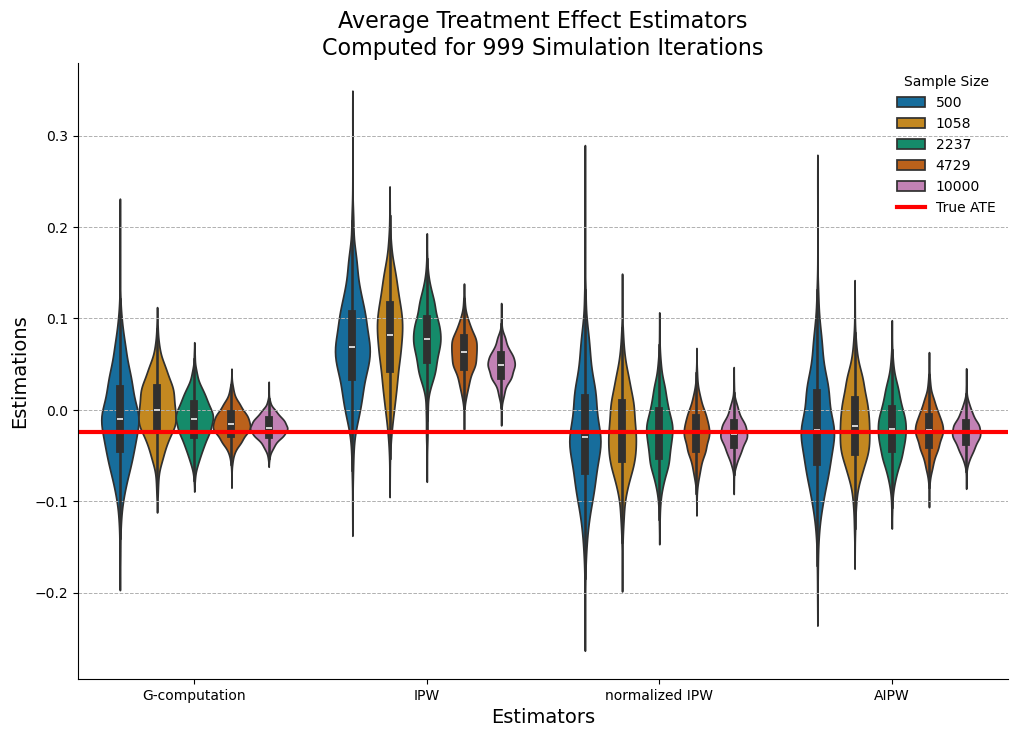

In [96]:
plot_violin(violin_df, true_ate);

The violin plot above depicts the distribution of 999 estimates for the estimators $\hat{\Delta}_G$, $\hat{\Delta}_{IPW}$, $\hat{\Delta}_{nIPW}$, and $\hat{\Delta}_{AIPW}$. Note the bell-shaped violins: even at $n=500$, they demonstrate the **asymptotic normality of the estimators**. Estimators with distributions centered on the statistical target $\Delta$ are considered **unbiased**. For a given sample size, the distribution of estimates varies in variance from one estimator to another, highlighting differences in efficiency. Finally, observe that for all estimators, the variance decreases as the sample size increases. An estimator is said to be **consistent** if both its bias (the difference between the center of the distribution and the statistical target) and variance shrink to zero as the sample size increases.

### 3. Describe How Estimator Variances Shrink as Sample Size Increases

* Take the log of the sample sizes and variances to see what happens

In [101]:
# Prepare the data for visualization
# (this part is a bit convoluted and not particulary insighful)
loglog_df = pd.concat([np.log(float_res_df["s_size"]), np.log(float_res_df[[col for col in float_res_df.columns if "variance" in col]])], axis=1)
loglog_df.columns = ["log_s_size", "log_variance_gcomp", "log_variance_ipw", "log_variance_ipw_normalized", "log_variance_aipw"]
loglog_df

,log_s_size,log_variance_gcomp,log_variance_ipw,log_variance_ipw_normalized,log_variance_aipw
0,6.214608,-6.030724,-5.877490,-5.650291,-5.754082
1,6.964136,-6.838012,-6.008235,-6.227269,-6.400536
2,7.712891,-7.406275,-6.681252,-6.703789,-6.874170
3,8.461469,-8.185036,-7.527684,-7.398629,-7.556539
4,9.210340,-8.768565,-8.101950,-8.067416,-8.179016


* Plot the results in a log-log scale

In [104]:
def variance_plot(loglog_df):
    # Define the x-axis and y-axis columns
    x_col = 'log_s_size'
    loglog_df.columns = ["log_s_size", "G-computation", "IPW", "normalized IPW", "AIPW"]
    y_cols = ["G-computation", "IPW", "normalized IPW", "AIPW"]

    # Set the color palette to "colorblind"
    colors = sns.color_palette("colorblind", len(y_cols))

    # Create a scatter plot
    plt.figure(figsize=(8, 8))
    plt.grid(linestyle='--', linewidth=0.7)

    for i, y_col in enumerate(y_cols):
        # Scatter plot
        plt.scatter(loglog_df[x_col], loglog_df[y_col], label=y_col, color=colors[i], marker='o', s=100, zorder=3)
        
        # Calculate the regression line
        slope, intercept = np.polyfit(loglog_df[x_col], loglog_df[y_col], 1)
        regression_line = slope * loglog_df[x_col] + intercept
        
        # Plot the regression line
        plt.plot(loglog_df[x_col], regression_line, color=colors[i], linestyle='--', linewidth=2, label=None, zorder=2)

    # Add labels and legend
    plt.xlabel('Log Sample Size', fontsize=14)
    plt.ylabel('Log Estimator Variance', fontsize=14)
    plt.legend(frameon=True, title='Estimators')
    plt.title('Asymptotic Behavior of Estimators:\nVariances and Convergence Rates', fontsize=16)

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Show the plot
    plt.show()

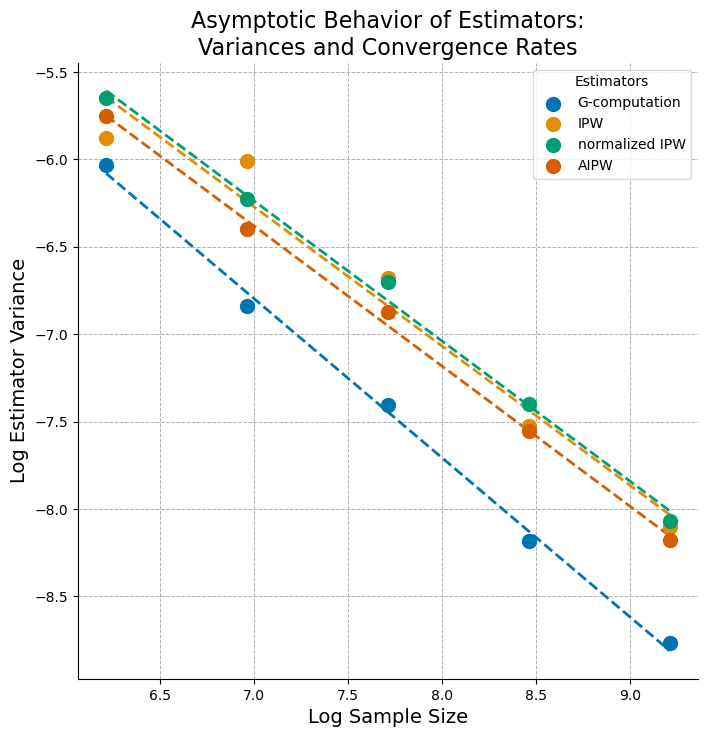

In [106]:
variance_plot(loglog_df)

* The scatter plot above illustrates how the variance of different estimators decreases as the sample size increases. Interestingly, the relationship between the log variance and log sample size appears approximately linear (when the sample size is sufficiently large). In practice, we aim for estimators whose variance decreases rapidly (the slope on the plot above indicates the **rate of convergence**) and whose initial variance is reasonably low (the intercept on the plot above indicates the estimator's **efficiency**). Ideally, we want estimators with high rates of convergence (very negative slopes on the plot above) and high efficiency (low intercepts on the plot above).

* It can be shown that no estimator can achieve a slope less than -1 on the plot above. In fact, in the plot above, all four estimators achieve a slope close to -1, indicating a rate of convergence of $\sqrt{n}$. All four estimators are **$\sqrt{n}$-consistent and asymptotically normal**. In this tutorial, we have covered these terms in detail. That's all for now. See you in the next one! 😊

## Conclusion
- Causal inference and estimation theory are intimately connected.
    * Researchers in causal inference often aim to: i) propose new relevant statistical causal targets, or ii) develop new estimators for existing targets that are consistent, efficient, and achieve fast convergence rates.
    * As we illustrated above, machine learning can be used to estimate the so-called nuisance components (e.g., propensity scores or prognostic functions) while using statistical methods to precisely study the properties of estimators.
    * For some estimators, such as AIPW, it is possible to calculate asymptotic (i.e., non-bootstrap) confidence intervals for your estimators despite using black-box machine learning methods for the nuisance component (though we have not illustrated this point here).
- There exist many other causal targets beyond the average treatment effect (e.g., CACE, CATE, etc.). These are beyond the scope of this tutorial but generally, the strategy to develop good estimators is similar to what we exposed here:
    * Precisely define your target in terms of potential outcomes.
    * Make your causal assumptions explicit and use them to eliminate the potential outcomes from your target.
    * Manipulate the resulting expression (possibly applying the efficient influence function recipe) to propose estimators.
    * Study the behavior of your proposed estimators through Monte Carlo simulations.

## Further reading
- [Dynamic Treatment Regimes: Statistical Methods for Precision Medicine (CRC Press, 2019)](https://www.taylorfrancis.com/books/mono/10.1201/9780429192692/dynamic-treatment-regimes-anastasios-tsiatis-marie-davidian-shannon-holloway-eric-laber): An excellent textbook that also covers sequential decision-making and finite horizon reinforcement learning in medicine.
- [Stefan Wager's Textbook on Causal Inference](https://web.stanford.edu/~swager/causal_inf_book.pdf): An authoritative resource that integrates perspectives from econometrics. Chapters 1-3 cover the theory of the estimators presented in this tutorial.
- [Demystifying Statistical Learning Based on Efficient Influence Functions](https://www.tandfonline.com/doi/full/10.1080/00031305.2021.2021984): This paper provides a clear introduction to efficient influence functions, a crucial tool for combining machine learning and semiparametric methods in causal inference.

## Bonus: Confidence Intervals for AIPW Estimates—Accounting for Machine Learning in Nuisance Components
<details>
    <summary>See bonus section</summary>

When leveraging machine learning for the nuisance components (i.e., the prognostic function $q(\cdot)$ or the propensity score $e(\cdot)$), it becomes challenging to construct well-performing confidence intervals using G-computation or IPW estimators. Notably, confidence intervals based on the bootstrap technique will also tend to underperform.
Fortunately, double robust estimators such as the AIPW estimator can address this issue effectively. **Simply put, if you aim to perform causal inference with machine learning and want reliable confidence intervals, double robust estimators like AIPW are essential**. Let's walk through this step-by-step.
### 1. Formula for Estimating the Variance of the AIPW Estimator
To streamline the notation, we rewrite the AIPW estimator as follows:
$$
\begin{align*}
&\hat{\Delta}_{AIPW}=n^{-1}\sum_{i=1}^n \hat{\Gamma}_i, \quad \text{where}\\
&\hat{\Gamma}_i=\hat{q}(1,X_i)-\hat{q}(0,X_i) + \frac{(2T_i-1)\{Y_i-\hat{q}(T_i,X_i)\}}{T_i\hat{e}(X_i) +(1-T_i)\{1-\hat{e}(X_i)\}}.
\end{align*}
$$
[Chernozhukov, et al.](https://academic.oup.com/ectj/article/21/1/C1/5056401) (Econometrics Journal, 2018) demonstrated that even with machine learning applied to the nuisance components $q(\cdot)$ and $e(\cdot),$ under mild technical conditions, you can use the following estimator for the variance of the AIPW estimator:
$$
\begin{align*}
&\hat{\text{VAR}}_P(\hat{\Delta}_{AIPW})=\frac{1}{n(n-1)}\sum_{i=1}^n \Big\{\hat{q}(1,X_i)-\hat{q}(0,X_i) + \frac{(2T_i-1)\{Y_i-\hat{q}(T_i,X_i)\}}{T_i\hat{e}(X_i) +(1-T_i)\{1-\hat{e}(X_i)\}}-\hat{\Delta}_{AIPW}\Big\}^2.
\end{align*}
$$
Thus, the confidence intervals around the AIPW estimate can be calculated as:
$$
\hat{\text{CI}}^{AIPW}_{1-\alpha/2}(\Delta)=\hat{\Delta}_{AIPW} ± z_{1-\alpha/2} \sqrt{\hat{\text{VAR}}_P(\hat{\Delta}_{AIPW})}
$$
where for 95% confidence intervals, we set $\alpha=0.05$ and use the corresponding normal quantile $z_{1-0.05/2}\approx1.96.$
### 2. Evaluating Whether the Resulting Confidence Intervals Achieve Nominal Coverage
</details>

In [112]:
# Prepare the data for studying the confidence intervals
ci_result = np.array([[ sim_res.s_size, sim_res.ci_length, sim_res.coverage] for sim_res in all_results])

In [114]:
def plot_ci_perf(ci_result):
    categories = ci_result[:, 0].astype(int)
    x_values = ci_result[:, 1]
    y_values = ci_result[:, 2]

    # Create a custom palette
    unique_categories = np.unique(categories)
    custom_palette = {category: color for category, color in zip(unique_categories, sns.color_palette("colorblind", len(unique_categories)))}

    # Create a scatter plot
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=x_values, y=y_values, hue=categories, palette=custom_palette, marker='P', s=300, zorder=3)
    plt.axhline(y=0.95, color='black', linestyle='--', linewidth=4, zorder=2, label='95% Coverage')

    # Set the y-axis limits
    plt.ylim(0, 1)

    # Set the title and labels
    plt.title(f'95% Asymptotic CIs for the AIPW Estimator\nComputed for {all_results[0].n_sim} Simulation Iterations', fontsize=16)
    plt.xlabel('Mean Confidence Interval Width', fontsize=14)
    plt.ylabel('Coverage Probability', fontsize=14)

    plt.legend(frameon=False, title='Sample Size')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Show the plot
    plt.show()

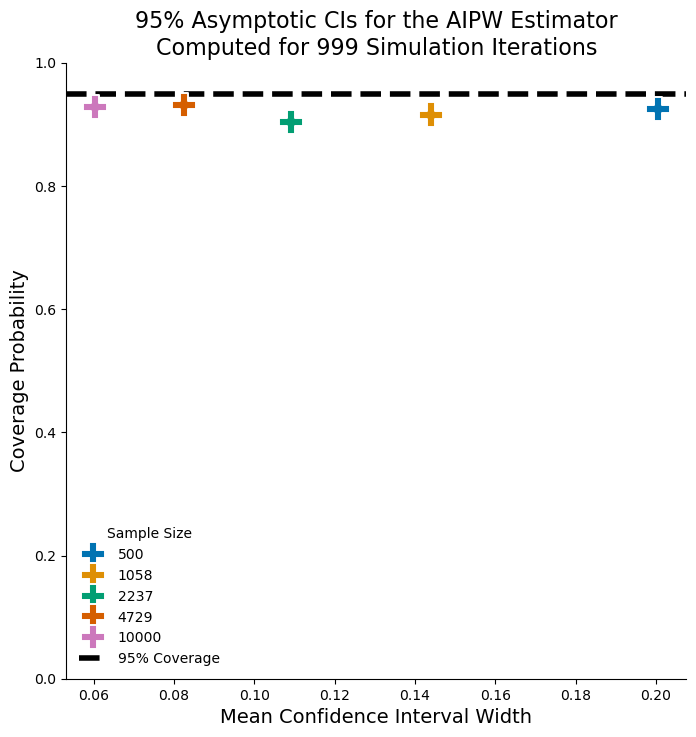

In [116]:
plot_ci_perf(ci_result)

<details>
    <summary>Bonus: Interpretation of the Above Figure</summary>

To generate the figure above, we used $999$ datasets with sizes $n = 500, 1058, 2237, 4729, 10000$. 
- For each dataset, we calculated the AIPW estimate of the average treatment effect using machine learning (multilayer perceptron) for the prognostic and propensity nuisance components. 
- For each dataset, we calculated the 95% confidence intervals around these estimates using the formula provided in the (hidden) bonus section above.
- For each sample size, we determined the fraction of confidence intervals that contain the true value. 

Remarkably, even for small sample sizes, approximately 95% of the 999 confidence intervals contain the true value. This demonstrates that the confidence intervals empirically **achieve their nominal coverage**.

This is a significant finding: despite using complex machine learning models, we were able to calculate reliable and easily computable (i.e., non-bootstrap) confidence intervals.

</details>